In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image


import pathlib

tf.config.list_physical_devices("GPU")

[]

In [ ]:
from google.colab import drive
from sklearn.utils.class_weight import compute_class_weight

drive.mount('/content/drive')

!cp -r "/content/drive/MyDrive/TxState/2025_Fall/Plant_Project/plant-seedlings-classification" /content/

train_path = "/content/plant-seedlings-classification/train"
test_path = "/content/plant-seedlings-classification/test"

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

# no augmentation for validation generator
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)


class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3840 images belonging to 12 classes.
Found 955 images belonging to 12 classes.
Class weights: {0: np.float64(1.5165876777251184), 1: np.float64(0.9846153846153847), 2: np.float64(1.391304347826087), 3: np.float64(0.65439672801636), 4: np.float64(1.807909604519774), 5: np.float64(0.8421052631578947), 6: np.float64(0.6106870229007634), 7: np.float64(1.807909604519774), 8: np.float64(0.7729468599033816), 9: np.float64(1.7297297297297298), 10: np.float64(0.7804878048780488), 11: np.float64(1.0062893081761006)}


In [ ]:
test_dir = pathlib.Path(test_path)
test_files = list(test_dir.glob("*.png"))
len(test_files)
print(train_generator.num_classes)


12


In [ ]:
# Model 3 — Transfer Learning using MobileNetV2

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)


x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(train_generator.num_classes, activation="softmax")(x)

model3 = keras.Model(inputs, outputs)

model3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
#    class_weight=class_weights
)

# now unfreezes training

for layer in base_model.layers[-40:]:
    layer.trainable = True

print("Base model trainable layers:",
      sum([layer.trainable for layer in base_model.layers]))

model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
#    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.2974 - loss: 2.2020 - val_accuracy: 0.6555 - val_loss: 1.0631
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.6203 - loss: 1.1352 - val_accuracy: 0.7351 - val_loss: 0.8190
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.6910 - loss: 0.8970 - val_accuracy: 0.7675 - val_loss: 0.7451
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step - accuracy: 0.7341 - loss: 0.7831 - val_accuracy: 0.7927 - val_loss: 0.7036
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.7790 - loss: 0.6803 - val_accuracy: 0.7979 - val_loss: 0.6511
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 304s 3s/step - accuracy: 0.7721 - loss: 0.6707 - val_accuracy: 0.7969 - val_loss: 0.6483
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.7970 - loss: 0.6146 - val_accuracy: 0.8094 - val_loss: 0.6032
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.7886 - loss: 0.5980 - val_accu

In [ ]:
model3.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_7 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_7 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 12)             │        15,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,667,174 (21.62 MB)

 Trainable params: 1,696,908 (6.47 MB)

 Non-trainable params: 576,448 (2.20 MB)

 Optimizer params: 3,393,818 (12.95 MB)

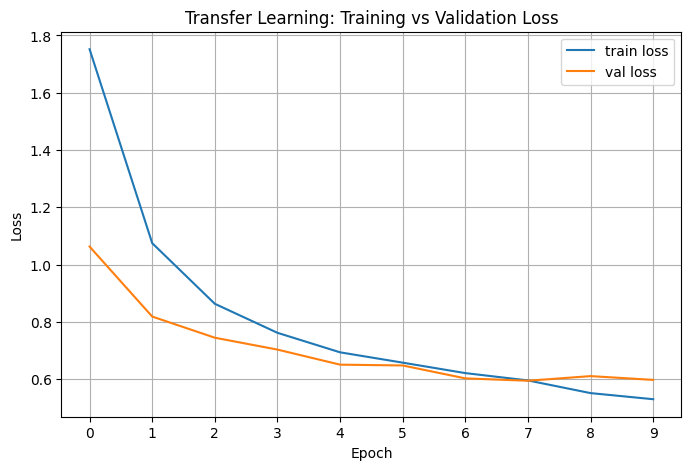

In [ ]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Transfer Learning: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

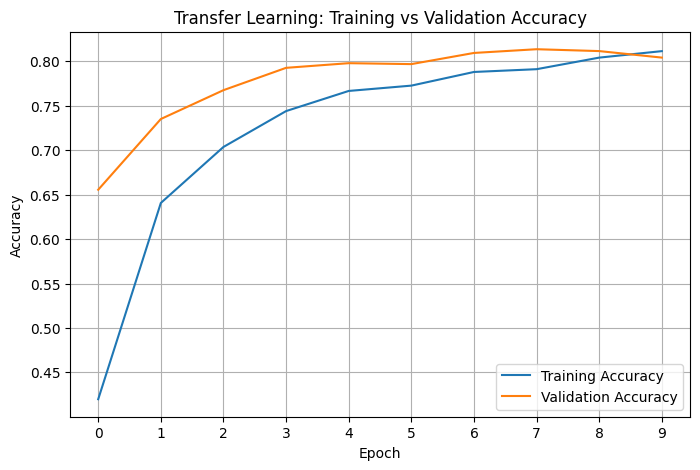

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Transfer Learning: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
predictions = []


def load_test_image(path):
    img = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    img = image.img_to_array(img)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    return np.expand_dims(img, axis=0)

for path in test_files:
    img = load_test_image(path)
    probs = model3.predict(img, verbose=0)
    pred_idx = np.argmax(probs)
    pred_class = idx_to_class[pred_idx]
    predictions.append([path.name, pred_class])

df = pd.DataFrame(predictions, columns=["file", "species"])
df.to_csv("seedling_predictions_model3.csv", index=False)